In [188]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
# below are for 3D scatter plots
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

## Combine Data Frames for Clustering

In [189]:
# read in all files 

# reservoir data
res = pd.read_csv('reservoir_cleaned.csv')
# api data
api = pd.read_csv('weather_api_data.csv')
# surface temperature (surfTemp)
surfTemp = pd.read_csv('clean_surface_temp_data.csv')
# deep water temperature (deepTemp)
deepTemp = pd.read_csv('clean_deep_temp_data.csv')
# dissolved oxygen (do)
do = pd.read_csv('clean_DO_data.csv')
# cyanotaxa data (algae)
algae = pd.read_csv('clean_HAB_data.csv')

In [190]:
res = res.fillna('None') # fill NAs with none

In [191]:
# focus on 5 desired reservoirs for algae
algae = algae[(algae['reservoir'] == 'BHR') | (algae['reservoir'] == 'BRR') | (algae['reservoir'] == 'CBR') | (algae['reservoir'] == 'NRR') | (algae['reservoir'] == 'WFR')]
algae = algae.reset_index(drop = True) # reset index
algae = algae.drop('Unnamed: 0', axis = 1)

# focus on 5 desired reservoirs for surface water temperatures
surfTemp = surfTemp[(surfTemp['reservoir'] == 'BHR') | (surfTemp['reservoir'] == 'BRR') | (surfTemp['reservoir'] == 'CBR') | (surfTemp['reservoir'] == 'NRR') | (surfTemp['reservoir'] == 'WFR')]
surfTemp= surfTemp.reset_index(drop = True) # reset index
surfTemp = surfTemp.drop('Unnamed: 0', axis = 1)

# focus on 5 desired reservoirs for deepwater temperatures
deepTemp = deepTemp[(deepTemp['reservoir'] == 'BHR') | (deepTemp['reservoir'] == 'BRR') | (deepTemp['reservoir'] == 'CBR') | (deepTemp['reservoir'] == 'NRR') | (deepTemp['reservoir'] == 'WFR')]
deepTemp= deepTemp.reset_index(drop = True) # reset index
deepTemp = deepTemp.drop('Unnamed: 0', axis = 1)

# focus on 5 desired reservoirs for dissolved oxygen
do = do[(do['reservoir'] == 'BHR') | (do['reservoir'] == 'BRR') | (do['reservoir'] == 'CBR') | (do['reservoir'] == 'NRR') | (do['reservoir'] == 'WFR')]
do = do.reset_index(drop = True) # reset index
do = do.drop('Unnamed: 0', axis = 1)



In [192]:
# get monthly average for surface water temperature for every year
monthly_avg_ST = surfTemp.groupby(['reservoir', 'yearmonth'])['temperature'].mean()
monthly_avg_ST = pd.DataFrame(monthly_avg_ST).reset_index()
monthly_avg_ST.rename(columns = {'temperature':'m_avg_surf_temp'}, inplace = True)

# get monthly average for deep water temperature for every year
monthly_avg_DT = deepTemp.groupby(['reservoir', 'yearmonth'])['temperature'].mean()
monthly_avg_DT = pd.DataFrame(monthly_avg_DT).reset_index()
monthly_avg_DT.rename(columns = {'temperature':'m_avg_deep_temp'}, inplace = True)

# get monthly average for dissolved oxygen for every year
monthly_avg_DO = do.groupby(['reservoir', 'yearmonth'])['do'].mean()
monthly_avg_DO = pd.DataFrame(monthly_avg_DO).reset_index()
monthly_avg_DO.rename(columns = {'do':'m_avg_dissolved_oxygen'}, inplace = True)

# get monthly average for algal bloom density 
algae_monthly = algae.groupby(['reservoir', 'order', 'yearmonth'])['density_cells/ml'].mean()
algae_monthly = pd.DataFrame(algae_monthly).reset_index()


In [193]:
# merge yearly monthly average deep water temperature, surface water temperature, and dissolved oxygen with algae monthly data
algae_monthly = pd.merge(algae_monthly, monthly_avg_DT, on=['reservoir', 'yearmonth'], how='left')
algae_monthly = pd.merge(algae_monthly, monthly_avg_ST, on=['reservoir', 'yearmonth'], how='left')
algae_monthly = pd.merge(algae_monthly, monthly_avg_DO, on=['reservoir', 'yearmonth'], how='left')
algae_monthly.dropna(inplace = True)
algae_monthly.reset_index(drop = True)
algae_monthly.head()

,reservoir,order,yearmonth,density_cells/ml,m_avg_deep_temp,m_avg_surf_temp,m_avg_dissolved_oxygen
1,BHR,Chroococcales,199206,1630.434783,18.641379,23.762500,6.041379
2,BHR,Chroococcales,199307,111.428571,21.703571,30.925000,0.885714
3,BHR,Chroococcales,199807,3.295680,21.683333,28.583333,1.262500
4,BHR,Chroococcales,200306,215.295238,18.387097,23.937500,5.861290
5,BHR,Chroococcales,200606,3.390667,17.814286,25.675000,5.021429


In [194]:
# get yearly monthly averages for temperature, daylight duration, and precipitation from the api data
api_temp = api.groupby(['reservoir', 'yearmonth'])['temperature'].mean()
api_temp = pd.DataFrame(api_temp).reset_index()
api_daylight = api.groupby(['reservoir', 'yearmonth'])['daylight_duration'].mean()
api_daylight = pd.DataFrame(api_daylight).reset_index()
api_precipitation = api.groupby(['reservoir', 'yearmonth'])['precipitation_sum'].mean()
api_precipitation = pd.DataFrame(api_precipitation).reset_index()

# merge yearly monhtly averages for temperature, daylight duration, and precipitation with the algae monthly data 
algae_monthly = pd.merge(algae_monthly, api_temp, on=['reservoir', 'yearmonth'], how='left')
algae_monthly = pd.merge(algae_monthly, api_precipitation, on=['reservoir', 'yearmonth'], how='left')
algae_monthly = pd.merge(algae_monthly, api_daylight, on=['reservoir', 'yearmonth'], how='left')

In [195]:
# add the type, stratification, latitude, and longitude for each reservoir

# create empty lists
type = []
strat = []
lat = []
long = []

# create a for loop to run through the monthly algae data frame and add the appropriate values to each list
for i in range(len(algae_monthly)):
    if algae_monthly['reservoir'][i] == 'BHR': # check for BHR
        type.append(*res[res['reservoir_abbreviation'] == 'BHR']['type'])
        strat.append(*res[res['reservoir_abbreviation'] == 'BHR']['stratification'])
        lat.append(*res[res['reservoir_abbreviation'] == 'BHR']['latitude'])
        long.append(*res[res['reservoir_abbreviation'] == 'BHR']['longitude'])
    elif algae_monthly['reservoir'][i] == 'BRR': # check for BRR
        type.append(*res[res['reservoir_abbreviation'] == 'BRR']['type'])
        strat.append(*res[res['reservoir_abbreviation'] == 'BRR']['stratification'])
        lat.append(*res[res['reservoir_abbreviation'] == 'BRR']['latitude'])
        long.append(*res[res['reservoir_abbreviation'] == 'BRR']['longitude'])
    elif algae_monthly['reservoir'][i] == 'CBR': # check for CBR
        type.append(*res[res['reservoir_abbreviation'] == 'CBR']['type'])
        strat.append(*res[res['reservoir_abbreviation'] == 'CBR']['stratification'])
        lat.append(*res[res['reservoir_abbreviation'] == 'CBR']['latitude'])
        long.append(*res[res['reservoir_abbreviation'] == 'CBR']['longitude'])
    elif algae_monthly['reservoir'][i] == 'NRR': # check for NRR
        type.append(*res[res['reservoir_abbreviation'] == 'NRR']['type'])
        strat.append(*res[res['reservoir_abbreviation'] == 'NRR']['stratification'])
        lat.append(*res[res['reservoir_abbreviation'] == 'NRR']['latitude'])
        long.append(*res[res['reservoir_abbreviation'] == 'NRR']['longitude'])
    elif algae_monthly['reservoir'][i] == 'WFR': # check for WFR
        type.append(*res[res['reservoir_abbreviation'] == 'WFR']['type'])
        strat.append(*res[res['reservoir_abbreviation'] == 'WFR']['stratification'])
        lat.append(*res[res['reservoir_abbreviation'] == 'WFR']['latitude'])
        long.append(*res[res['reservoir_abbreviation'] == 'WFR']['longitude'])

# add the lists to the algae monthly data frame
algae_monthly['type'] = type
algae_monthly['stratification'] = strat
algae_monthly['latitude'] = lat
algae_monthly['longitude'] = long

In [196]:
algae_monthly['temp_diff'] = algae_monthly['m_avg_surf_temp'] - algae_monthly['m_avg_deep_temp']

In [197]:
algae_monthly

,reservoir,order,yearmonth,density_cells/ml,m_avg_deep_temp,m_avg_surf_temp,m_avg_dissolved_oxygen,temperature,precipitation_sum,daylight_duration,type,stratification,latitude,longitude,temp_diff
0,BHR,Chroococcales,199206,1630.434783,18.641379,23.762500,6.041379,20.540000,3.580000,52903.894000,Forest,Strong,37.3386,-83.4707,5.121121
1,BHR,Chroococcales,199307,111.428571,21.703571,30.925000,0.885714,27.074194,2.283871,51969.053548,Forest,Strong,37.3386,-83.4707,9.221429
2,BHR,Chroococcales,199807,3.295680,21.683333,28.583333,1.262500,24.312903,2.032258,51984.238710,Forest,Strong,37.3386,-83.4707,6.900000
3,BHR,Chroococcales,200306,215.295238,18.387097,23.937500,5.861290,20.513333,5.406667,52892.536333,Forest,Strong,37.3386,-83.4707,5.550403
4,BHR,Chroococcales,200606,3.390667,17.814286,25.675000,5.021429,21.473333,3.690000,52897.074000,Forest,Strong,37.3386,-83.4707,7.860714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,WFR,Nostocales,201609,4389.562149,24.550000,25.683333,0.105000,22.280000,2.153333,44676.637667,Urban,None,39.2607,-84.4975,1.133333
575,WFR,Nostocales,201706,4599.692533,23.800000,25.365000,2.130000,22.000000,4.076667,53590.810667,Urban,None,39.2607,-84.4975,1.565000
576,WFR,Synechococcales,201609,22637.764458,24.550000,25.683333,0.105000,22.280000,2.153333,44676.637667,Urban,None,39.2607,-84.4975,1.133333
577,WFR,Synechococcales,201706,87080.543850,23.800000,25.365000,2.130000,22.000000,4.076667,53590.810667,Urban,None,39.2607,-84.4975,1.565000


In [198]:
algae['order'].unique()

array(['Nostocales', 'Pseudanabaenales', 'Chroococcales',
       'Oscillatoriales', 'Synechococcales', 'Unkown', 'Spirulinales'],
      dtype=object)

In [199]:
# export algae monthly dataframe 
algae_monthly.to_csv('algae_monthly.csv')

## Run KMeans Clustering 
I want to run KMeans clustering based on algae density, deep water DO concentrations, and temperature differences. 

In [200]:
# create a data frame with the desired features for clustering
features = ['density_cells/ml', 'm_avg_dissolved_oxygen', 'temp_diff']
cluster_df = algae_monthly[features]
cluster_df.to_csv('cluster_df.csv')
# scale the values so that mean is 0 and SD is 1
X = StandardScaler().fit_transform(cluster_df)
X = pd.DataFrame(X, columns = features)
X.to_csv('cluster_df_scaled.csv')

#### Elbow Method

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

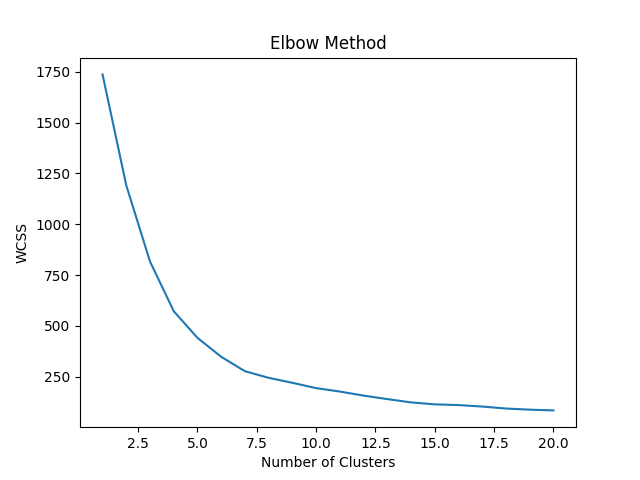

In [201]:
# calculate KMeans inertia for clusters 1 through 20
wcss = [] 
for i in range(1, 21):
    km = KMeans(n_clusters = i)
    km.fit_predict(X)
    wcss.append(km.inertia_)

# plot the # of Clusters vs WCSS to identify optimal number of clusters
figE = plt.figure()
plt.plot(range(1, 21), wcss)
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()

Based on the plot above I think that 7 clusters might be the optimal number of clusters. 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


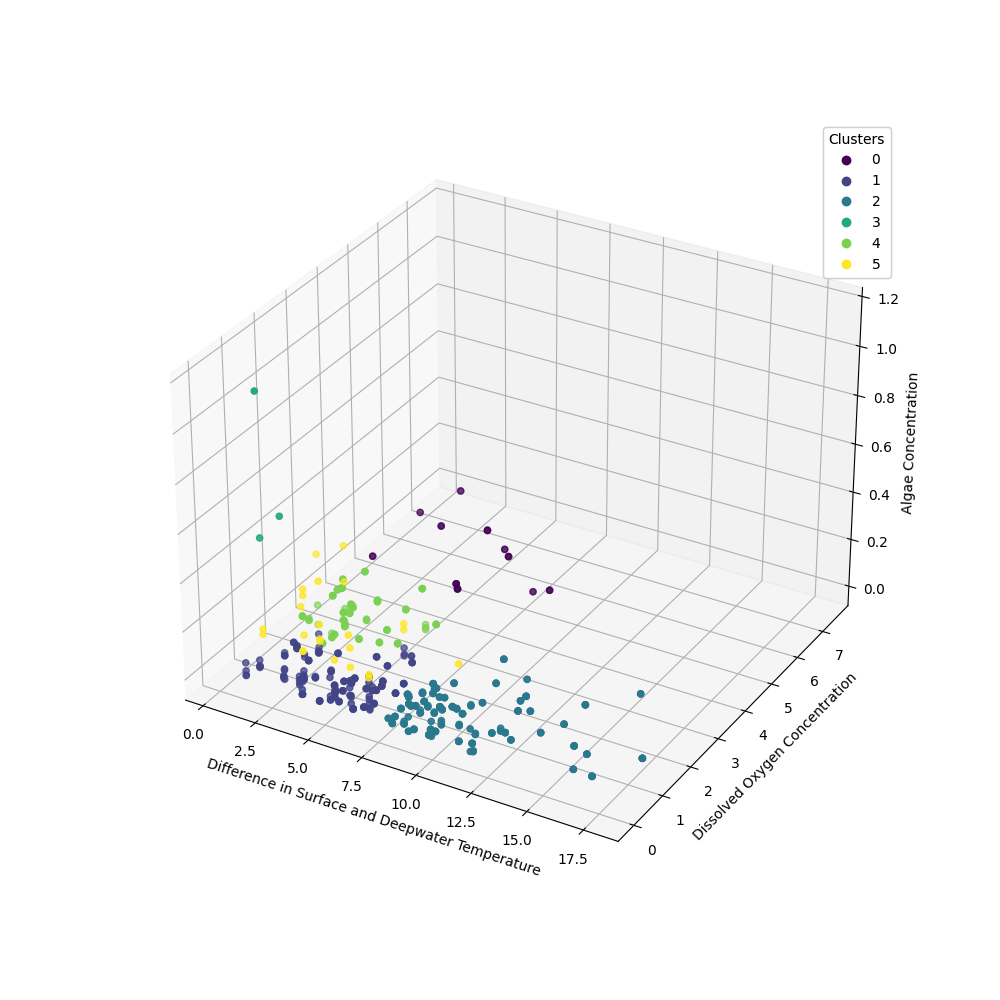

In [202]:
# run K-Means with 6 clusters
model_6 = KMeans(n_clusters = 6)
kmeans_6 = model_6.fit_predict(X)

# add values to dataframe
algae_monthly['6_kmeans'] = kmeans_6

# plot the data in 3D scatter plot
fig1 = plt.figure(figsize = (10,10))
ax = fig1.add_subplot(projection='3d')

x = algae_monthly['temp_diff']
y = algae_monthly['m_avg_dissolved_oxygen']
z = algae_monthly['density_cells/ml']


scatter = ax.scatter(x, y, z, c = algae_monthly['6_kmeans'])
ax.set_xlabel('Difference in Surface and Deepwater Temperature')
ax.set_ylabel('Dissolved Oxygen Concentration')
ax.set_zlabel('Algae Concentration')
# Create a legend
# Create a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)


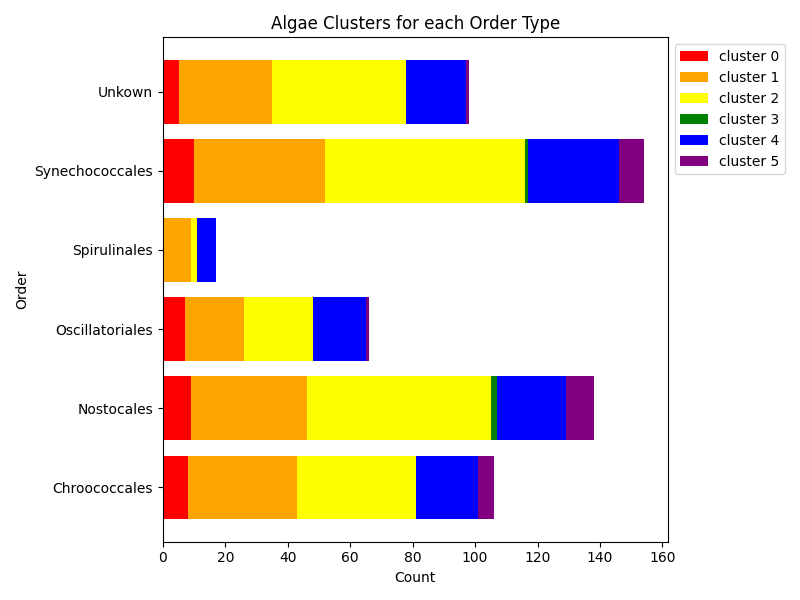

In [203]:
# group by cluster and order
o = algae_monthly.groupby('order')['6_kmeans'].value_counts().unstack().reset_index().fillna(0)
# plot the data
figOrd = plt.figure(figsize=(8,6))
plt.barh(o['order'], o[0], color='red', label='cluster 0')
plt.barh(o['order'], o[1], color='orange', label='cluster 1', left=o[0])
plt.barh(o['order'], o[2], color='yellow', label='cluster 2', left=o[0]+o[1])
plt.barh(o['order'], o[3], color='green', label='cluster 3', left=o[0]+o[1]+o[2])
plt.barh(o['order'], o[4], color='blue', label='cluster 4', left=o[0]+o[1]+o[2]+o[3])
plt.barh(o['order'], o[5], color='purple', label='cluster 5', left=o[0]+o[1]+o[2]+o[3]+o[4])
plt.title('Algae Clusters for each Order Type')
plt.xlabel('Count')
plt.ylabel('Order')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### Silhouette Method

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

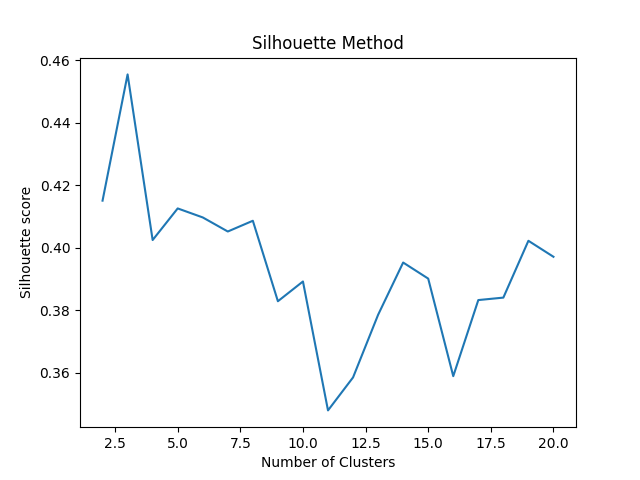

In [204]:
# calculate the average silhouette score for clusters 2-21
silhouette_avg = []
for j in range(2, 21):
    # initialise kmeans
    kmeans = KMeans(n_clusters = j)
    # get the average silhouette score
    silhouette_avg.append(silhouette_score(X, kmeans.fit_predict(X)))

# create silhouette plot
figSil = plt.figure()
plt.plot(range(2, 21), silhouette_avg)
plt.xlabel('Number of Clusters') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette Method')
plt.show()

The silhouette method shows 3 as the optimal number of clusters. 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


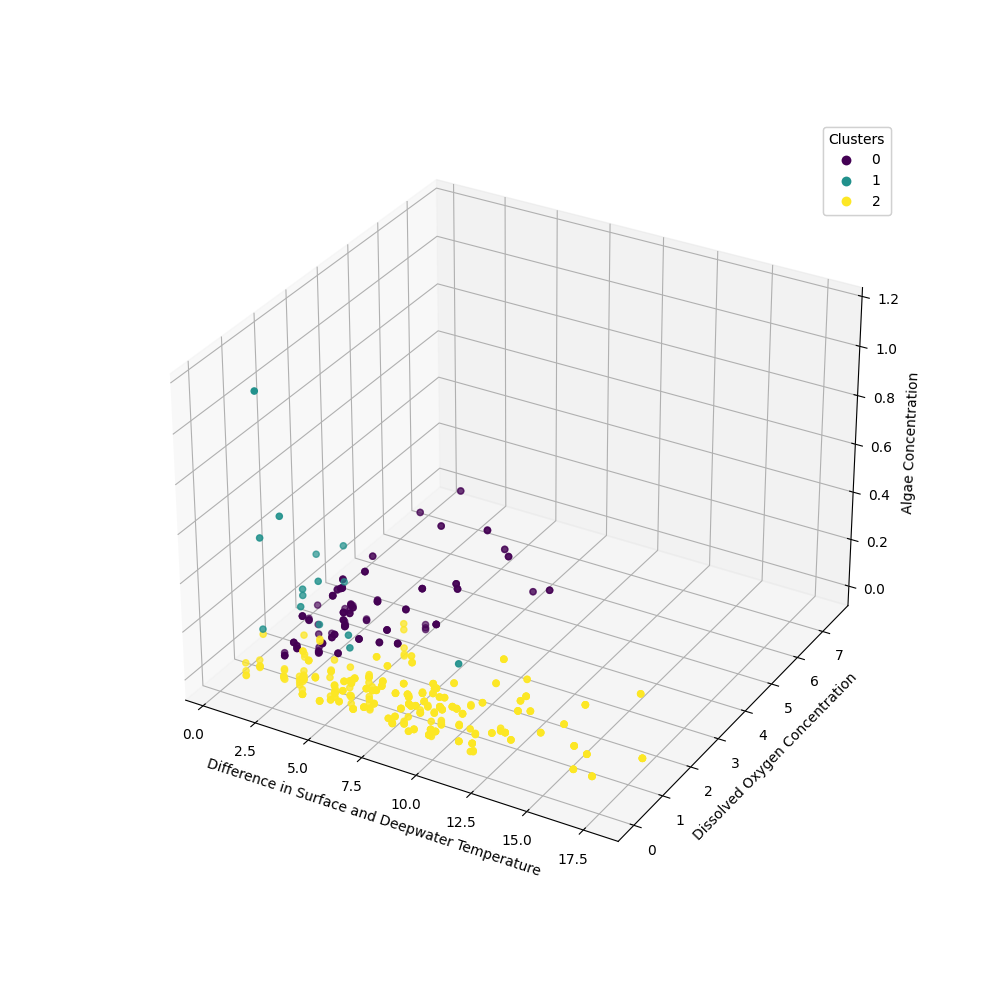

In [205]:
# run K-Means with 3 clusters
model_3 = KMeans(n_clusters = 3)
kmeans_3 = model_3.fit_predict(X)

# add values to dataframe
algae_monthly['3_kmeans'] = kmeans_3

# plot the data in 3D scatter plot
fig2 = plt.figure(figsize = (10,10))
ax = fig2.add_subplot(projection='3d')

x = algae_monthly['temp_diff']
y = algae_monthly['m_avg_dissolved_oxygen']
z = algae_monthly['density_cells/ml']


scatter = ax.scatter(x, y, z, c = algae_monthly['3_kmeans'])
ax.set_xlabel('Difference in Surface and Deepwater Temperature')
ax.set_ylabel('Dissolved Oxygen Concentration')
ax.set_zlabel('Algae Concentration')
# Create a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)


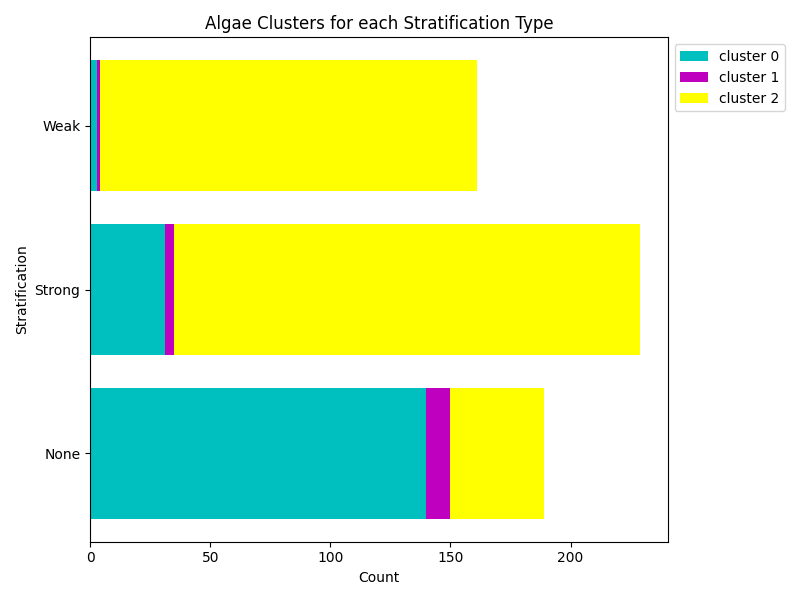

In [206]:
# compare clusters and stratification
# group by cluster and order
s = algae_monthly.groupby('stratification')['3_kmeans'].value_counts().unstack().reset_index().fillna(0)
# plot the data
fig2 = plt.figure(figsize=(8,6))
plt.barh(s['stratification'], s[0], color='c', label='cluster 0')
plt.barh(s['stratification'], s[1], color='m', label='cluster 1', left=s[0])
plt.barh(s['stratification'], s[2], color='yellow', label='cluster 2', left=s[0]+s[1])

plt.title('Algae Clusters for each Stratification Type')
plt.xlabel('Count')
plt.ylabel('Stratification')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


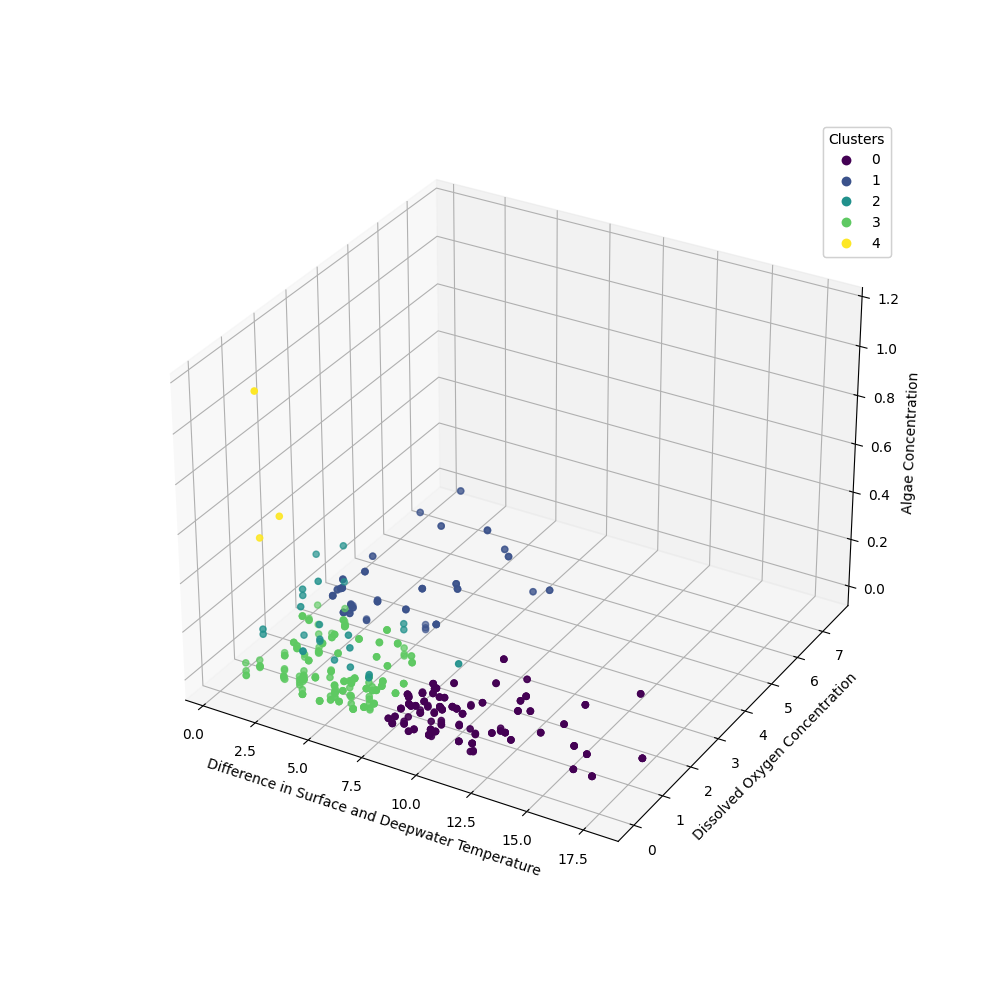

In [207]:
# KMeans clustering with 5 clusters, then will look at cluster and reservoir type
# run K-Means with 3 clusters
model_5 = KMeans(n_clusters = 5)
kmeans_5 = model_5.fit_predict(X)

# add values to dataframe
algae_monthly['5_kmeans'] = kmeans_5

# plot the data in 3D scatter plot
fig3 = plt.figure(figsize = (10,10))
ax = fig3.add_subplot(projection='3d')

x = algae_monthly['temp_diff']
y = algae_monthly['m_avg_dissolved_oxygen']
z = algae_monthly['density_cells/ml']


scatter = ax.scatter(x, y, z, c = algae_monthly['5_kmeans'])
ax.set_xlabel('Difference in Surface and Deepwater Temperature')
ax.set_ylabel('Dissolved Oxygen Concentration')
ax.set_zlabel('Algae Concentration')
# Create a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)



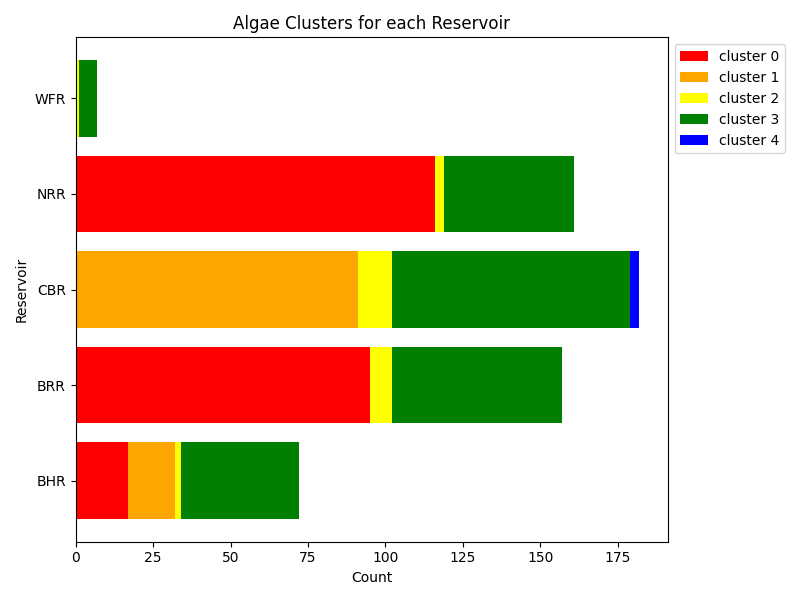

In [208]:
# group by cluster (5) and reservoir
r = algae_monthly.groupby('reservoir')['5_kmeans'].value_counts().unstack().reset_index().fillna(0)
# plot the data
figreRK = plt.figure(figsize=(8,6))
plt.barh(r['reservoir'], r[0], color='red', label='cluster 0')
plt.barh(r['reservoir'], r[1], color='orange', label='cluster 1', left=r[0])
plt.barh(r['reservoir'], r[2], color='yellow', label='cluster 2', left=r[0]+r[1])
plt.barh(r['reservoir'], r[3], color='green', label='cluster 3', left=r[0]+r[1]+r[2])
plt.barh(r['reservoir'], r[4], color='blue', label='cluster 4', left=r[0]+r[1]+r[2]+r[3])
plt.title('Algae Clusters for each Reservoir')
plt.xlabel('Count')
plt.ylabel('Reservoir')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Run Hierarchical Clustering 
This is specifically for all numerical features, besides latitude and longitude.

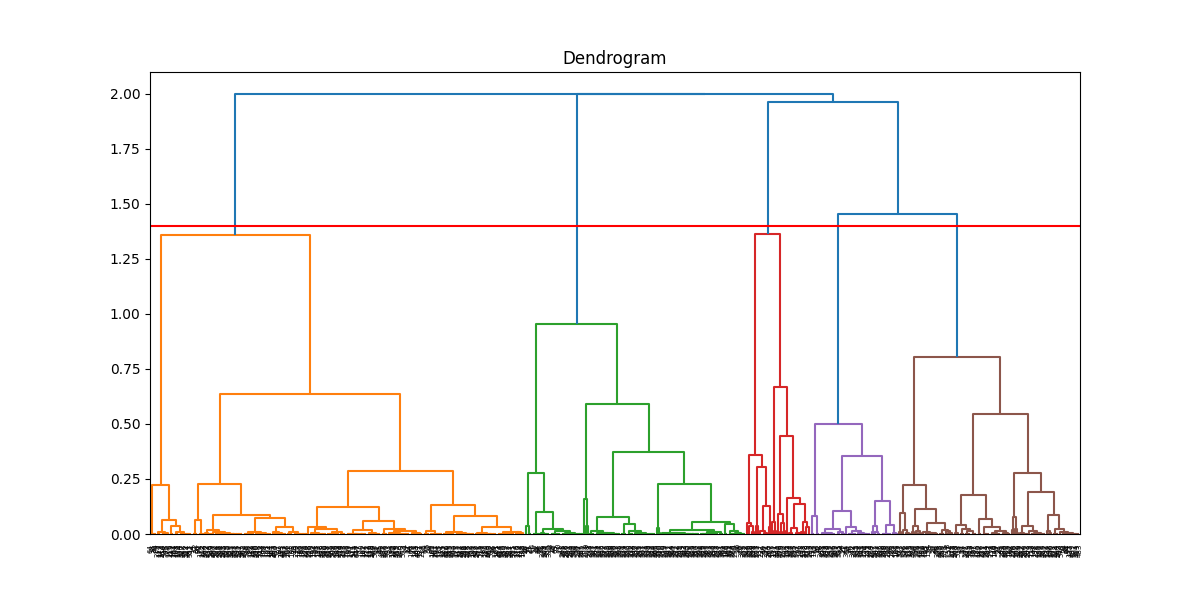

In [209]:
# run agglomerative hierarchical clustering with all the features (besides latitude and longitude) 
# uses the cosine similarity metric with complete linkage
hier = shc.linkage(X, method='complete',metric ='cosine')
    
# plot the dendrogram
figD = plt.figure(figsize = (12, 6))
shc.dendrogram(hier)
plt.title('Dendrogram')
plt.axhline(y=1.4, color='r') # adds a line to show optimal number of clusters
plt.show()

The hierarchical clustering worked much better than kmeans clustering with the optimal number of clusters as 5. 

In [210]:
# cluster the data using agglomerative clustering with cosine similarity with complete linkage
h_cluster = AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='complete')
labels = h_cluster.fit_predict(X)
algae_monthly['h_cluster'] = labels
algae_monthly

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


,reservoir,order,yearmonth,density_cells/ml,m_avg_deep_temp,m_avg_surf_temp,m_avg_dissolved_oxygen,temperature,precipitation_sum,daylight_duration,type,stratification,latitude,longitude,temp_diff,6_kmeans,3_kmeans,5_kmeans,h_cluster
0,BHR,Chroococcales,199206,1630.434783,18.641379,23.762500,6.041379,20.540000,3.580000,52903.894000,Forest,Strong,37.3386,-83.4707,5.121121,0,0,1,2
1,BHR,Chroococcales,199307,111.428571,21.703571,30.925000,0.885714,27.074194,2.283871,51969.053548,Forest,Strong,37.3386,-83.4707,9.221429,2,2,0,1
2,BHR,Chroococcales,199807,3.295680,21.683333,28.583333,1.262500,24.312903,2.032258,51984.238710,Forest,Strong,37.3386,-83.4707,6.900000,1,2,3,1
3,BHR,Chroococcales,200306,215.295238,18.387097,23.937500,5.861290,20.513333,5.406667,52892.536333,Forest,Strong,37.3386,-83.4707,5.550403,0,0,1,2
4,BHR,Chroococcales,200606,3.390667,17.814286,25.675000,5.021429,21.473333,3.690000,52897.074000,Forest,Strong,37.3386,-83.4707,7.860714,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,WFR,Nostocales,201609,4389.562149,24.550000,25.683333,0.105000,22.280000,2.153333,44676.637667,Urban,None,39.2607,-84.4975,1.133333,1,2,3,3
575,WFR,Nostocales,201706,4599.692533,23.800000,25.365000,2.130000,22.000000,4.076667,53590.810667,Urban,None,39.2607,-84.4975,1.565000,4,0,3,4
576,WFR,Synechococcales,201609,22637.764458,24.550000,25.683333,0.105000,22.280000,2.153333,44676.637667,Urban,None,39.2607,-84.4975,1.133333,1,2,3,3
577,WFR,Synechococcales,201706,87080.543850,23.800000,25.365000,2.130000,22.000000,4.076667,53590.810667,Urban,None,39.2607,-84.4975,1.565000,4,0,3,0


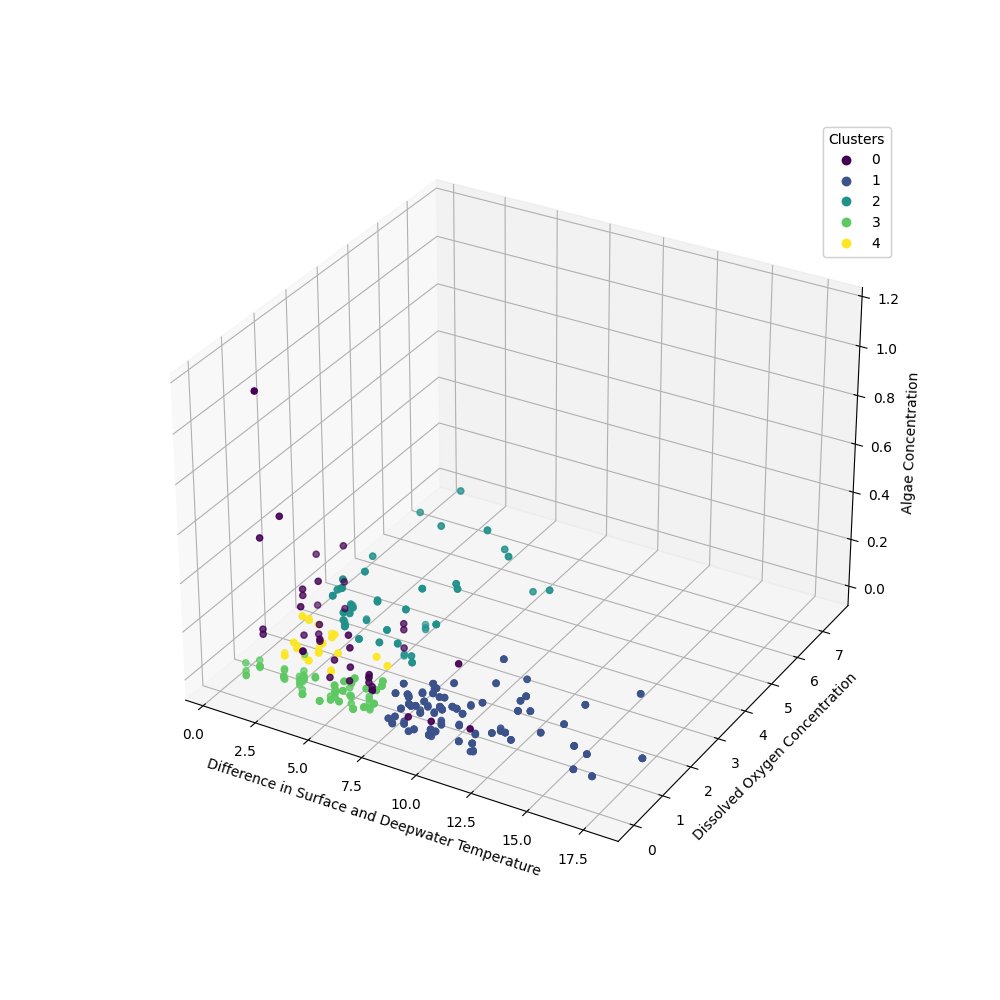

In [211]:
# Plot hierarchical clusters
# plot the data in 3D scatter plot
figH = plt.figure(figsize = (10,10))
ax = figH.add_subplot(projection='3d')

x = algae_monthly['temp_diff']
y = algae_monthly['m_avg_dissolved_oxygen']
z = algae_monthly['density_cells/ml']


scatter = ax.scatter(x, y, z, c = algae_monthly['h_cluster'])
ax.set_xlabel('Difference in Surface and Deepwater Temperature')
ax.set_ylabel('Dissolved Oxygen Concentration')
ax.set_zlabel('Algae Concentration')
# Create a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

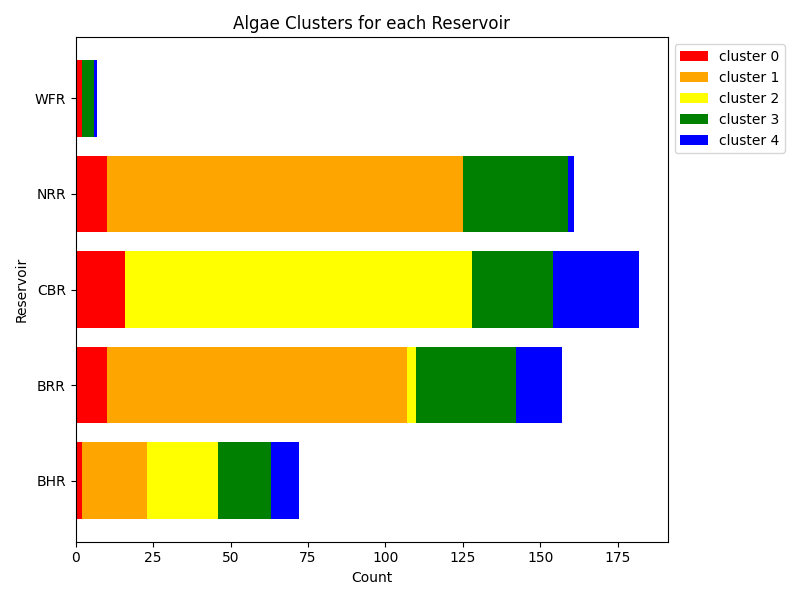

In [212]:
# group data by reservoir and cluster
h = algae_monthly.groupby('reservoir')['h_cluster'].value_counts().unstack().reset_index().fillna(0)

# plot the data
figRH = plt.figure(figsize=(8,6))
plt.barh(h['reservoir'], h[0], color='red', label='cluster 0')
plt.barh(h['reservoir'], h[1], color='orange', label='cluster 1', left=h[0])
plt.barh(h['reservoir'], h[2], color='yellow', label='cluster 2', left=h[0]+h[1])
plt.barh(h['reservoir'], h[3], color='green', label='cluster 3', left=h[0]+h[1]+h[2])
plt.barh(h['reservoir'], h[4], color='blue', label='cluster 4', left=h[0]+h[1]+h[2]+h[3])

plt.title('Algae Clusters for each Reservoir')
plt.xlabel('Count')
plt.ylabel('Reservoir')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## PCA

In [213]:
# create a scaled data frame with the desired features for PCA
features2 = ['density_cells/ml', 'm_avg_dissolved_oxygen', 'temp_diff', 'temperature', 'precipitation_sum', 'daylight_duration']
pca_df = algae_monthly[features2]
pca_df.to_csv('pca_df.csv')
# scale the values so that mean is 0 and SD is 1
scaled = StandardScaler().fit_transform(pca_df)
scaled = pd.DataFrame(scaled, columns = features2)
scaled.to_csv('pca_df_scaled.csv')

In [214]:
scaled.head()

,density_cells/ml,m_avg_dissolved_oxygen,temp_diff,temperature,precipitation_sum,daylight_duration
0,-0.206145,2.964649,-0.316920,-1.268434,0.513843,0.921441
1,-0.226480,-0.457800,0.737202,1.700044,-0.455134,0.636857
2,-0.227927,-0.207681,0.140401,0.445593,-0.643238,0.641480
3,-0.225089,2.845102,-0.206558,-1.280548,1.879446,0.917983
4,-0.227926,2.287582,0.387385,-0.844421,0.596078,0.919364


In [215]:
pca_df.head()

,density_cells/ml,m_avg_dissolved_oxygen,temp_diff,temperature,precipitation_sum,daylight_duration
0,1630.434783,6.041379,5.121121,20.540000,3.580000,52903.894000
1,111.428571,0.885714,9.221429,27.074194,2.283871,51969.053548
2,3.295680,1.262500,6.900000,24.312903,2.032258,51984.238710
3,215.295238,5.861290,5.550403,20.513333,5.406667,52892.536333
4,3.390667,5.021429,7.860714,21.473333,3.690000,52897.074000


In [216]:
# run PCA on the scaled clustering data X
pca = PCA(n_components = 6) # there are 6 features
pca.fit(scaled)
# get the scores
scores = pca.transform(scaled)
# create a data frame for the scores of each principle component (7)
# create the data frame
df_scores = pd.DataFrame(scores, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
df_scores

,PC1,PC2,PC3,PC4,PC5,PC6
0,2.317096,-1.883218,-0.835674,0.787032,1.175187,0.199523
1,-1.872170,-0.298867,-0.232444,0.511064,-0.242552,0.582094
2,-0.646725,-0.176330,-0.405040,0.567807,-0.443241,-0.079548
3,2.379916,-2.547209,-0.044427,-0.080298,1.383172,0.359017
4,1.329810,-1.818417,-0.582180,0.573547,1.267120,-0.010884
...,...,...,...,...,...,...
574,0.711202,1.899017,-0.185097,-0.899393,-0.930960,0.028224
575,1.229126,-1.249193,0.372927,-0.020023,-0.943350,0.078636
576,0.740778,1.972679,-0.004250,-0.767270,-0.876800,0.044907
577,1.362808,-0.916244,1.190346,0.577168,-0.698550,0.154043


In [217]:
explained_variance = pca.explained_variance_ratio_
explain_variance = np.insert(explained_variance, 0, 0) # adds an origin
expl_var_df = pd.DataFrame(explain_variance, columns=['Explained Variance'])
expl_var_df

,Explained Variance
0,0.000000
1,0.341665
2,0.216455
3,0.184988
4,0.124422
5,0.080386
6,0.052085


In [218]:
# calculate cumulative variance to 4 decimal places and put it in a data frame
cumulative_variance = np.cumsum(np.round(explained_variance, decimals = 4))
cumulative_variance = np.insert(cumulative_variance, 0, 0) #adds an origin
cumulative_var_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])
cumulative_var_df

,Cumulative Variance
0,0.0000
1,0.3417
2,0.5582
3,0.7432
4,0.8676
5,0.9480
6,1.0001


In [219]:
pc_df = pd.DataFrame(['','PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], columns=['PC'])
df_expl_var = pd.concat([pc_df, expl_var_df, cumulative_var_df], axis=1)
df_expl_var

,PC,Explained Variance,Cumulative Variance
0,,0.000000,0.0000
1,PC1,0.341665,0.3417
2,PC2,0.216455,0.5582
3,PC3,0.184988,0.7432
4,PC4,0.124422,0.8676
5,PC5,0.080386,0.9480
6,PC6,0.052085,1.0001


Text(0, 0.5, 'Variance')

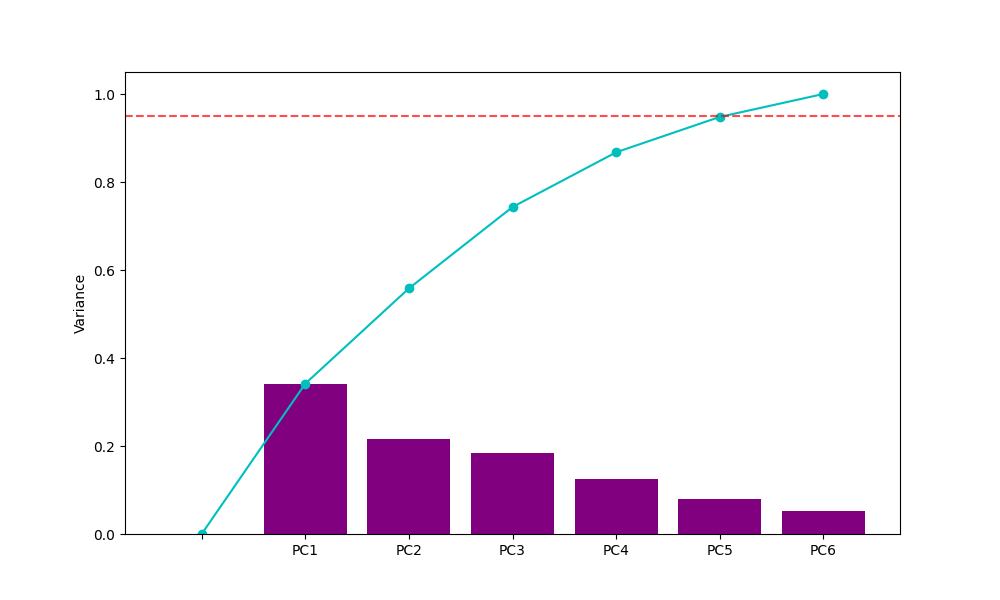

In [220]:
# create a plot visualizing the explained and cumulative variance
plt.figure(figsize = (10, 6))
expl_var = plt.bar(df_expl_var['PC'], df_expl_var['Explained Variance'], color = 'purple')
cumul_var = plt.plot(df_expl_var['PC'], df_expl_var['Cumulative Variance'], marker = 'o', color = 'c')
plt.axhline(y=0.95, color='r', linestyle = '--', alpha = 0.7) 
plt.ylabel('Variance')

In [221]:
# Find the loadings since they tell us about each feature
loading = pca.components_.T[:,0:5] # this helps focus on the first 3 principle components
loading = pd.DataFrame(loading, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index = features2 ) # create a dataframe
# add a column that calculates the total variation each feature explains for the principle components
loading['abs_total'] = abs(loading['PC1']) + abs(loading['PC2']) + abs(loading['PC3']) + abs(loading['PC4']) + abs(loading['PC5'])

loading = loading.sort_values('abs_total', ascending = True).reset_index(names = 'feature')
loading

,feature,PC1,PC2,PC3,PC4,PC5,abs_total
0,temperature,-0.626196,-0.023135,-0.007208,0.100680,-0.084719,0.841938
1,temp_diff,-0.580578,-0.141710,-0.024349,0.009104,0.692891,1.448632
2,daylight_duration,-0.118898,-0.728725,0.087128,0.499292,-0.383351,1.817393
3,density_cells/ml,0.121073,0.301543,0.740314,0.540860,0.221709,1.925498
4,precipitation_sum,0.130273,-0.501174,0.560267,-0.600290,0.145249,1.937253
5,m_avg_dissolved_oxygen,0.474386,-0.325945,-0.360277,0.295990,0.543613,2.000209


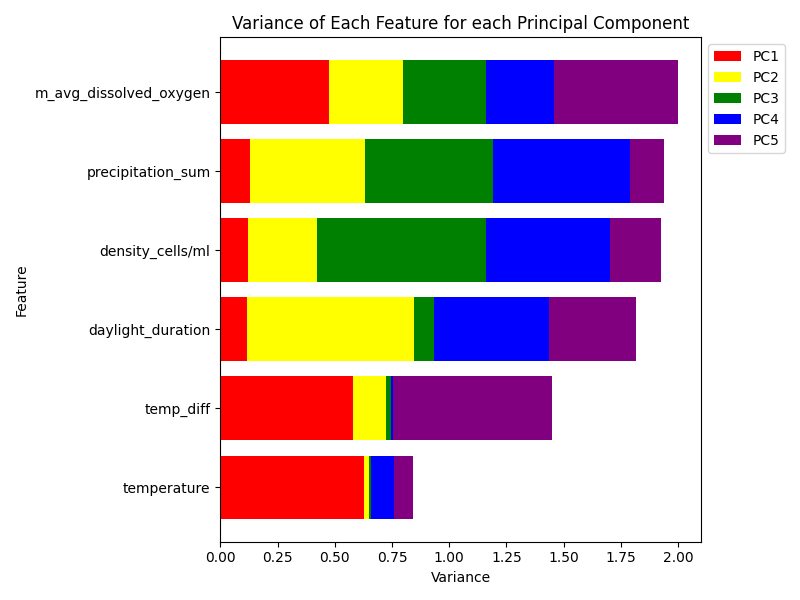

In [222]:
# plot the data
figPCAvar = plt.figure(figsize=(8,6))
# Compute the left offset for each PC
left_offset_pc2 = loading['PC1'].abs()
left_offset_pc3 = left_offset_pc2 + loading['PC2'].abs()
left_offset_pc4 = left_offset_pc3 + loading['PC3'].abs()
left_offset_pc5 = left_offset_pc4 + loading['PC4'].abs()

# Plot each principal component contribution for each feature
plt.barh(loading['feature'], loading['PC1'].abs(), color='red', label='PC1')
plt.barh(loading['feature'], loading['PC2'].abs(), color='yellow', label='PC2', left=left_offset_pc2)
plt.barh(loading['feature'], loading['PC3'].abs(), color='green', label='PC3', left=left_offset_pc3)
plt.barh(loading['feature'], loading['PC4'].abs(), color='blue', label='PC4', left=left_offset_pc4)
plt.barh(loading['feature'], loading['PC5'].abs(), color='purple', label='PC5', left=left_offset_pc5)

plt.title('Variance of Each Feature for each Principal Component')
plt.xlabel('Variance')
plt.ylabel('Feature')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

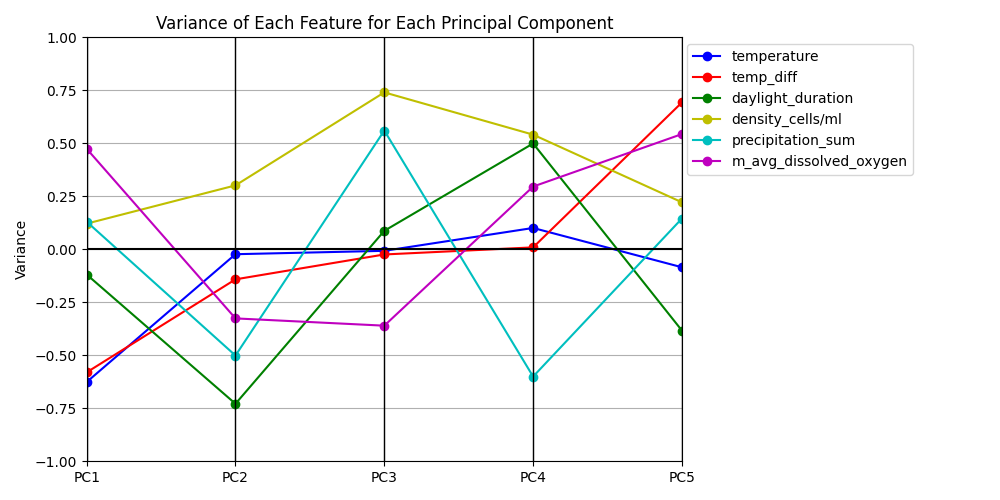

In [223]:
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates

data = loading[['feature', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5']]
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'c', 'm']), None, len(data)))
figPCA = plt.figure(figsize=(10,5)).gca().axes.set_ylim([-1,+1])
parallel_coordinates(data, 'feature', color = my_colors, marker = 'o')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.axhline(y=0, color = 'black')
plt.ylabel('Variance')
plt.title('Variance of Each Feature for Each Principal Component')
plt.tight_layout()